## Image segmentation with Unet

In [441]:
#model: https://arxiv.org/abs/1505.04597
#data: https://www.kaggle.com/c/tgs-salt-identification-challenge/data

In [2]:
import numpy as np
import os, glob, shutil
from matplotlib import pyplot as plt
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Reshape
from keras import regularizers
from keras.backend import int_shape
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
exampledir = "tgs-salt/test0/"
example_image = plt.imread(exampledir + "/images/0c02f95a08.png")
example_mask = plt.imread(exampledir + "/masks/0c02f95a08.png")

### Dense neural network

<img src="files/img/dense.png"></img>

<img src="files/img/neuron.png"></img>

### Dense neural net vs Sparse neural net

<img src="files/img/sparse.png"></img>

### Example of our data

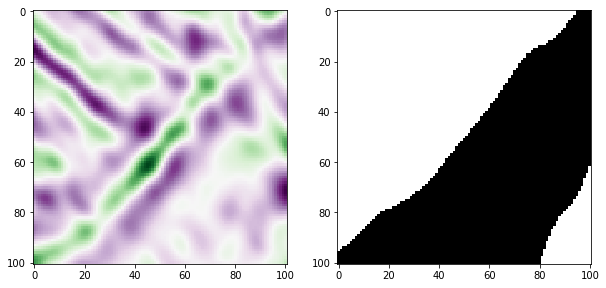

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(10,10))

ax[0].imshow(example_image[:,:,0], cmap='PRGn');
ax[1].imshow(example_mask, cmap='Greys');

### Unet Model

<img src="files/img/unet.png"></img>

#### Add input layer

In [404]:
input_ = Input(shape=(101, 101, 1))

#### Add convolution layer

<img src="files/img/no_padding_no_strides.gif"></img>

<img src="files/img/same_padding_no_strides.gif"></img>

In [405]:
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(input_)

In [406]:
x = Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(x)

#Check the dimensions:
int_shape(x)

#### Save the output  (we'll need it later)

In [407]:
pass1 = x

#### Add Pooling layer to decrease resolution (downsampling)

<img src="files/img/pooling.png"></img>

In [408]:
x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)

#Check the dimensions:
int_shape(x)

(None, 50, 50, 64)

#### Add convolutional layers (bottleneck)

In [409]:
x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
x = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)

#Check the dimensions:
int_shape(x)

(None, 50, 50, 128)

#### Upsampling: add transposed convolutional layer:

<img src="files/img/padding_strides_transposed.gif"></img>

In [410]:
x = Conv2DTranspose(filters=64, kernel_size=(3,3), strides=(2,2), padding='valid', output_padding=(0,0))(x)

#Check dimensions:
int_shape(x)

(None, 101, 101, 64)

#### Concatenate with the output of previous layer that we saved:

In [411]:
x = Concatenate()([x, pass1])

#Check the dimensions:
int_shape(x)

(None, 101, 101, 128)

#### Add few more convolutional layers

In [412]:
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(x)

#Check the dimensions
int_shape(x)

(None, 101, 101, 64)

#### Add final activation layer (sigmoid)

In [413]:
x = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid')(x)

#Check the dimensions
int_shape(x)

(None, 101, 101, 1)

#### Build a model

In [432]:
model = Model(inputs=input_, outputs=x)

#### Compile the model

In [437]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Try to fit the model to the example image:

In [438]:
model.fit(x=example_image[:,:,0][np.newaxis,...,np.newaxis], y = example_mask[np.newaxis,..., np.newaxis], epochs=50)

Epoch 1/50
1/1 [==============================] - 1s 627ms/step - loss: 0.2401 - accuracy: 0.8954
Epoch 2/50
1/1 [==============================] - 0s 289ms/step - loss: 1.8551 - accuracy: 0.6603
Epoch 3/50
1/1 [==============================] - 0s 231ms/step - loss: 0.5283 - accuracy: 0.7922
Epoch 4/50
1/1 [==============================] - 0s 267ms/step - loss: 0.5262 - accuracy: 0.7219
Epoch 5/50
1/1 [==============================] - 0s 249ms/step - loss: 0.4601 - accuracy: 0.7881
Epoch 6/50
1/1 [==============================] - 0s 236ms/step - loss: 0.5085 - accuracy: 0.7007
Epoch 7/50
1/1 [==============================] - 0s 237ms/step - loss: 0.4594 - accuracy: 0.7849
Epoch 8/50
1/1 [==============================] - 0s 239ms/step - loss: 0.3927 - accuracy: 0.8243
Epoch 9/50
1/1 [==============================] - 0s 244ms/step - loss: 0.3596 - accuracy: 0.8285
Epoch 10/50
1/1 [==============================] - 0s 244ms/step - loss: 0.3460 - accuracy: 0.8386
Epoch 11/50
1/1 [==

#### Make prediction and compare with the ground truth

In [439]:
pred = model.predict(example_image[:,:,0][np.newaxis,...,np.newaxis])

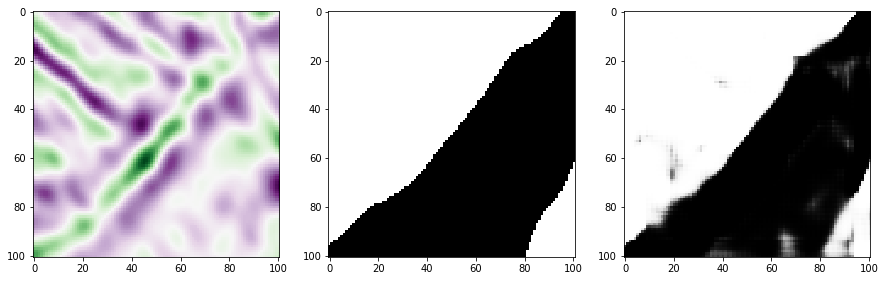

In [452]:
fig, ax = plt.subplots(1, 3, figsize=(15,15))

ax[0].imshow(example_image[:,:,0], cmap='PRGn');
ax[1].imshow(example_mask, cmap='Greys');
ax[2].imshow(pred[0,:,:,0], cmap='Greys');

In [ ]:
hst = model.fit_generator(data_generator2(testdir0, 1), steps_per_epoch=10, epochs=10, 
                    validation_data=data_generator2(testdir0, 1), validation_steps=10, validation_freq=1)

In [137]:
REGULARIZER = 0.0001
reg = regularizers.l2(l=REGULARIZER)

In [453]:
#Defines a Unet model with len(layers) number of layers
#i-th element of layers is the number of features in i-th layer
def buildModel(layers=[]):
    input_ = Input(shape=(101, 101, 1))
    passes = []
    paddings = []
    
    #downsampling
    x = input_
    for features in layers[:-1]:
        paddings.append(((int_shape(x)[-3]+1) % 2, (int_shape(x)[-2] +1) % 2))
        x = Conv2D(filters=features, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                   kernel_regularizer=reg)(x)
        x = Conv2D(filters=features, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                   kernel_regularizer=reg)(x)
        passes.append(x)
        x = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid')(x)

    #bottleneck
    x = Conv2D(filters=layers[-1], kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
              kernel_regularizer=reg)(x)
    x = Conv2D(filters=layers[-1], kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
              kernel_regularizer=reg)(x)
    
    #upsampling
    for features in layers[-2::-1]:
        z1 = passes.pop()
        pad = paddings.pop()
        z2 = Conv2DTranspose(filters=features, kernel_size=(3,3), strides=(2,2), padding='same', activation='relu',
                            output_padding=pad, kernel_regularizer=reg)(x)
        if int_shape(z2)[-3] < int_shape(z1)[-3]:
            z2 = Conv2DTranspose(filters=features, kernel_size=(3,3), strides=(2,2), padding='valid', 
                            output_padding=pad, kernel_regularizer=reg)(x)
        x=z2
        x = Concatenate()([x, z1])
        x = Conv2D(filters=features, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                  kernel_regularizer=reg)(x)
        x = Conv2D(filters=features, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu',
                  kernel_regularizer=reg)(x)

    x = Conv2D(filters=1, kernel_size=(1,1), strides=(1,1), padding='same', activation='sigmoid',
              kernel_regularizer=reg)(x)
    x = Reshape((-1, 1))(x)
    model = Model(inputs=input_, outputs=x)
    return model

In [298]:
#this creates a model
model = buildModel([16, 32, 64, 128, 256])

In [299]:
#compile it
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [259]:
#Use generators to create training data
#Randomly selects batch_size images and corresponding masks from the folder with the data

def data_generator(directory, batch_size=1):
    all_masks = os.listdir(directory + '/masks/')
    while True:
        try:
            masks = np.random.choice(all_masks, batch_size)
            images = [(plt.imread(directory + '/images/' + mask)[:,:,0][...,np.newaxis] - 128)/128 for mask in masks]
        except:
            print("Problem reading images.")
            break
        mask_img = [plt.imread(directory + '/masks/' + mask).ravel()[...,np.newaxis] for mask in masks]
        label_one_hot = [to_categorical(plt.imread(directory + '/masks/' + mask).ravel(), 2) for mask in masks]
        yield np.stack(images), np.stack(mask_img)

In [301]:
hst = model.fit_generator(data_generator(exampledir, 1), steps_per_epoch=10, epochs=10, 
                    validation_data=data_generator2(exampledir, 1), validation_steps=10, validation_freq=1)

Epoch 1/10
10/10 [==============================] - 2s 154ms/step - loss: 0.5905 - accuracy: 0.7143 - val_loss: 0.7148 - val_accuracy: 0.5671
Epoch 2/10
10/10 [==============================] - 2s 161ms/step - loss: 0.6618 - accuracy: 0.6623 - val_loss: 0.4772 - val_accuracy: 0.8353
Epoch 3/10
10/10 [==============================] - 2s 189ms/step - loss: 0.4171 - accuracy: 0.8293 - val_loss: 0.3333 - val_accuracy: 0.8939
Epoch 4/10
10/10 [==============================] - 2s 209ms/step - loss: 0.3134 - accuracy: 0.8878 - val_loss: 0.2424 - val_accuracy: 0.9151
Epoch 5/10
10/10 [==============================] - 2s 220ms/step - loss: 0.2334 - accuracy: 0.9250 - val_loss: 0.2185 - val_accuracy: 0.9282
Epoch 6/10
10/10 [==============================] - 2s 249ms/step - loss: 0.2057 - accuracy: 0.9366 - val_loss: 0.1853 - val_accuracy: 0.9461
Epoch 7/10
10/10 [==============================] - 2s 230ms/step - loss: 0.1472 - accuracy: 0.9544 - val_loss: 0.1191 - val_accuracy: 0.9615
Epoch 